# Dynamics Homework 2

Liam Dubay

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
G = 4*np.pi**2 # solar system units

This class keeps track of the binary stars' masses and positions over time. The center of mass is always at the origin. The binary orbits are assumed to be circular and are on rails to avoid issues with numerical precision.

In [2]:
class Binary:
    """Parameters and functions related to the central binary."""
    
    def __init__(self, mass1, mass2, separation, phase=0):
        """
        Parameters
        ----------
        mass1 : float
            Mass of primary star in solar masses
        mass2 : float
            Mass of secondary star in solar masses
        separation : float
            Separation of binary in AU
        phase : float
            Initial phase of binary from 0 to 1. A phase of 0 
            starts the primary mass on the positive x-axis.
        
        """
        self.m1 = mass1
        self.m2 = mass2
        self.mtot = mass1 + mass2
        self.sep = separation
        self.a1 = self.m2 / self.mtot * self.sep
        self.a2 = self.m1 / self.mtot * self.sep
        # Convert phase to angle
        self.phi0 = phase * 2*np.pi
        self.T = np.sqrt(self.sep**3/self.mtot)
        
    def acceleration(self, t, test_position):
        """
        Gravitational acceleration on a test particle due to the binary.
        """
        pos1, pos2 = self.positions(t)
        r1 = test_position - pos1
        r2 = test_position - pos2
        accel = -G * (self.m1 * r1 / np.sqrt(np.sum(r1**2))**3 + self.m2 * r2 / np.sqrt(np.sum(r2**2))**3)
        return accel
    
    def positions(self, t):
        """
        Cartesian positions of the two masses as a function of time.
        """
        # Orbital phase of the primary, m1
        phi = 2*np.pi/self.T * t + self.phi0
        # Keep phase < 2pi
        phi = phi - 2*np.pi * np.floor(phi / (2*np.pi))
        # Cartesian positions of m1 and m2
        pos1 = self.a1 * np.array([np.cos(phi), np.sin(phi)])
        pos2 = self.a2 * np.array([np.cos(phi+np.pi), np.sin(phi+np.pi)])
        return pos1, pos2
        
    def potential(self, t, test_position):
        """
        Gravitational potential of a test particle at a given position and time.
        """
        pos1, pos2 = self.positions(t)
        r1 = np.sqrt(np.sum((test_position - pos1)**2))
        r2 = np.sqrt(np.sum((test_position - pos2)**2))
        pot = -G * (self.m1 / r1 + self.m2 / r2)
        return pot

Test plots to make sure the binary is working as it should.

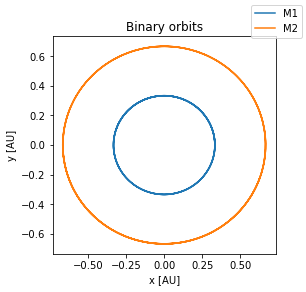

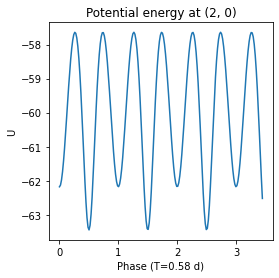

In [3]:
# Test code for binary star
binary = Binary(2, 1, 1, phase=0)
tarr = np.arange(0, 2, 0.01)

# Plot orbits
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(binary.positions(tarr)[0][0], binary.positions(tarr)[0][1], label='M1')
ax.plot(binary.positions(tarr)[1][0], binary.positions(tarr)[1][1], label='M2')
ax.set_title('Binary orbits')
ax.set_xlabel('x [AU]')
ax.set_ylabel('y [AU]')
fig.legend()
plt.show()

# Plot potential energy at test position
test_pos = np.array([2, 0])
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(tarr / binary.T, [binary.potential(t, test_pos) for t in tarr])
ax.set_title('Potential energy at (2, 0)')
ax.set_xlabel(f'Phase (T={binary.T:.02f} d)' % binary.T)
ax.set_ylabel('U')
plt.show()

This class tracks the position, energy, and momentum of the massless test particle over time. The move() function updates the particle's position based on its current velocity and the given time step, while the accelerate() function updates its velocity given an external acceleration vector. The function for calculating the acceleration is in the System class because it depends on the state of the binary as well.

In [231]:
class TestParticle():
    """Parameters, values, and functions for a massless test particle."""
    
    def __init__(self, primary_mass, a0, phase=0, sign=1):
        """
        Initialize test particle.
        
        Parameters
        ----------
        primary_mass : float
            Mass of primary (or total mass of binary) centered at
            the origin in solar masses.
        a0 : float
            Initial semi-major axis in AU.
        phase : float, optional
            Initial orbital phase, from 0 to 1. Default is 0,
            which is on the positive x-axis.
        sign : int, optional
            Sign of initial velocity. 1 is for a counter-clockwise orbit
            and -1 is for a clockwise orbit. Default is +1.
        
        """
        # Convert phase to angle
        phi = phase * 2*np.pi
        # Start at phase on circular orbit
        self.position = a0 * np.array([np.cos(phi), np.sin(phi)])
        v_circ = np.sqrt(G * primary_mass / a0)
        self.velocity = sign * v_circ * np.array([-np.sin(phi), np.cos(phi)])
        
    def accelerate(self, tstep, acceleration, update=True):
        """
        Accelerate body over the integration time step and re-calculate velocity.
        
        Parameters
        ----------
        tstep : float
            Integration time step in years.
        acceleration : numpy.ndarray
            Acceleration vector in solar system units.
        update : bool
            If True, update velocity in place. Default is True.
        """
        
        velocity = self.velocity + acceleration * tstep
        if update:
            self.velocity = velocity
        return velocity
    
    def angular_momentum(self):
        """
        Calculate the z-component of specific angular momentum.
        """
        
        return np.cross(self.position, self.velocity)
    
    def kinetic_energy(self):
        """
        Calculate the specific kinetic energy.
        """
        
        return 0.5 * np.sum(self.velocity**2)

    def move(self, tstep, update=True):
        """
        Move position over the integration time step according to the current velocity.
        
        Parameters
        ----------
        tstep : float
            Integration time step in years.
        update : bool
            If True, update position in place. Default is True.
        """
        
        position = self.position + self.velocity * tstep
        if update:
            self.position = position
        return position

The CircularThreeBody class is designed to serve as the front-end for the orbital integrator. It generates a Binary and TestParticle object based on the initial conditions of the system and tracks them over time via a leapfrog integrator. It also tracks various parameters of the system such as $x$ and $\dot x$ for the planet's surface-of-section plot and the Jacobi constant. The integration timestep dynamically adjusts based on the acceleration felt by the test mass, and the integrator is designed to automatically stop when the system becomes unbound.

In [233]:
class CircularThreeBody:
    """Set up and run a circular-restricted 3-body problem."""
    
    def __init__(self, m1, m2, sep, a0, phase=0, sign=1):
        """
        Initialize circular-restricted 3-body system with a central massive
        binary and a test mass on a circular orbit.
        
        Parameters
        ----------
        m1 : float
            Mass of primary in solar masses.
        m2 : float
            Mass of secondary in solar masses.
        sep : float
            Binary separation in AU.
        a0 : float
            Semi-major axis of test particle initial circular orbit in AU.
        phase : float, optional
            Initial phase of binary, with 0 corresponding to a conjunction
            with the primary closer to the test particle, and 0.5 corresponding
            to a conjunction with the secondary closer to the test particle.
            The default is 0.
        sign : int, optional
            Sign of initial velocity of the test mass. 1 is for a 
            counter-clockwise orbit and -1 is for a clockwise orbit. Default is 1.
        
        """
        self.binary = Binary(m1, m2, sep, phase=phase)
        self.planet = TestParticle(m1+m2, a0, phase=0, sign=sign)
        self.orbit_initial = self.orbital_elements()
        
    def jacobi(self, t):
        """
        Calculate Jacobi constant for circular binary + test particle system.
        """
        mean_motion = 2 * np.pi / self.binary.T
        energy_total = self.planet.kinetic_energy() + self.binary.potential(t, self.planet.position)
        return 2 * (mean_motion * self.planet.angular_momentum() - energy_total)
        
    def integrate(self, tmax, tstep):
        """
        Integrate circular-restricted 3-body orbits using leapfrog integration.
        
        Parameters
        ----------
        tmax : float
            Maximum integration time in years.
        tstep : float
            Integration step time in years.
        
        """
        # Initialize output dicts
        hist = { # tracks the entire history of the planet's position
            't': [],
            'x': [],
            'y': [],
            'Cj': []
        }
        sos = { # tracks the planet's surface-of-section plot
            't': [],
            'x': [],
            'xdot': []
        }

        # Initial values
        t = 0
        old_t = -1
        old_accel = np.sqrt(np.sum(self.binary.acceleration(t, self.planet.position)**2))
        with tqdm(total = int(tmax)) as pbar:
            while t < tmax:
                if np.around(2*t/tstep) % 2:
                    # Half-step: calculate acceleration and update velocity
                    acceleration = self.binary.acceleration(t, self.planet.position)
                    self.planet.accelerate(acceleration, tstep)
                    # Check if acceleration is significantly more or less than initial
                    # and adjust time step accordingly
                    accel_mag = np.sqrt(np.sum(acceleration**2))
                    if tstep >= 1e-5 and accel_mag > 10 * old_accel:
                        tstep *= 0.1
                        old_accel = accel_mag
                    elif tstep <= 0.1 and accel_mag < 0.1 * old_accel:
                        tstep *= 10
                        old_accel = accel_mag
                else:
                    # Full step: update position
                    old_y = self.planet.position[1]
                    self.planet.move(tstep)
                    # Record x-position and x-velocity once per orbit
                    if self.planet.position[1] >= 0 and old_y <= 0 and self.planet.velocity[1] > 0:
                        sos['t'].append(t)
                        sos['x'].append(self.planet.position[0])
                        sos['xdot'].append(self.planet.velocity[0])
                    # Record position every step
                    hist['t'].append(t)
                    hist['x'].append(self.planet.position[0])
                    hist['y'].append(self.planet.position[1])
                    hist['Cj'].append(self.jacobi(t))
                    # Each year, update progress bar and check for unbound orbit
                    if t >= old_t + 1:
                        old_t = t
                        pbar.update(1)
                        # If orbit is unbound, plot for one more year then stop
                        if self.orbital_elements()['e'] >= 1:
                            tmax = t + 1
                            print('System is unbound! Stopping integration in 1 year.')
                t += tstep/2

        self.history = hist
        self.sos = sos
        self.orbit_final = self.orbital_elements()
        return self.history
    
    def orbital_elements(self):
        """
        Convert planet's position and velocity into its Keplerian orbital elements about the origin.
        """
        M = self.binary.mtot
        r = np.sqrt(np.sum(self.planet.position**2))
        v = np.sqrt(np.sum(self.planet.velocity**2))
        a = (2/r - v**2/(G*M))**-1
        h = self.planet.angular_momentum()
        e = np.sqrt(max(1 - h**2/(a*G*M), 0))
        # eccentricity vector
        e_vec = h/(G*M) * np.array([self.planet.velocity[1], -self.planet.velocity[0]]) - self.planet.position/r
        # argument of periapsis (from positive x-axis)
        arg_peri = np.arctan2(e_vec[1], e_vec[0])
        return {'a': a, 'e': e, 'omega': arg_peri}

Now, some plotting functions: orbits, Jacobi constant, and surface-of-section.

In [207]:
def plot_system(system, xlim=None, ylim=None, nstep=1, title=''):
    hist = system.history
    binary = system.binary
    sos = system.sos
    
    fig = plt.figure(figsize=(8, 7.8))
    axs = []
    gs = fig.add_gridspec(2, 2, hspace=0.2, wspace=0.3)
    
    # Plot orbits
    ax = fig.add_subplot(gs[0,0])
    axs.append(ax)
    tarr = np.arange(0, binary.T, 1e-3)
    ax.plot(binary.positions(tarr)[0][0], 
            binary.positions(tarr)[0][1], 
            label='A')
    ax.plot(binary.positions(tarr)[1][0], 
            binary.positions(tarr)[1][1], 
            label='B')
    # Plot the planet's full trajectory
    ax.plot(hist['x'], hist['y'], label='b')
    ax.set_title('Orbits')
    ax.set_xlabel('x [AU]')
    ax.set_ylabel('y [AU]')
    ax.set_xlim(xlim)
    if xlim is not None and ylim is None:
        ylim = xlim
    ax.set_ylim(ylim)
    ax.legend(loc='upper left')
    
    # Plot surface-of-section
    ax = fig.add_subplot(gs[0,1])
    axs.append(ax)
    ax.scatter(sos['x'], sos['xdot'], s=5)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\dot x$', labelpad=-2)
    ax.set_title('Surface-of-section')
    
    # Plot Jacobi constant
    ax = fig.add_subplot(gs[1,:])
    axs.append(ax)
    ax.plot(hist['t'][::nstep], hist['Cj'][::nstep])
    ax.set_title('Jacobi constant')
    ax.set_xlabel('Time [yr]')
    ax.set_ylabel(r'$C_J$ [AU$^2$ yr$^{-2}$]')
    ax.ticklabel_format(useOffset=False)
    
    fig.suptitle(title)
    plt.show()

## Part 1: Wide Orbit

Here the planet starts with the same semi-major axis as we observe in the Kepler 16 system. The first simulation starts with the planet on the side of the more massive star (phase=0).

In [227]:
m1 = 0.6897
m2 = 0.20255
sep = 0.22431
a0 = 0.7048
sys1 = CircularThreeBody(m1, m2, sep, a0, phase=0)
hist = sys1.integrate(1e4, 1e-3)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [19:37<00:00,  8.49it/s]


The orbits look quite regular even after 10,000 years of integration. The surface-of-section plot shows the position and velocity oscillating around a stable point. The Jacobi constant is constant to within $10^{-4}$, which gives me confidence that my code is working correctly. (I'm plotting every 10,000 timesteps on the Jacobi plot for clarity).

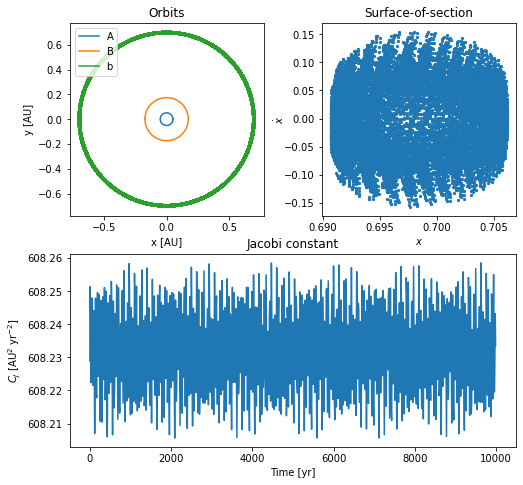

In [229]:
plot_system(sys1, nstep=10000)

The final semi-major axis of 0.7114 AU is quite close to the initial value of 0.7048, and the eccentricity has only risen to 0.024.

In [230]:
sys1.orbit_final

{'a': 0.7114180930293055,
 'e': 0.024028244606045187,
 'omega': -2.293848808580734}

Reversing the direction of the planet's initial velocity results in a less stable configuration. After only 100 orbits the eccentricity has already increased to 0.032, higher than the final value for the counter-clockwise orbit.

In [234]:
sys1a = CircularThreeBody(m1, m2, sep, a0, phase=0, sign=-1)
hist = sys1a.integrate(100, 1e-3)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.97it/s]


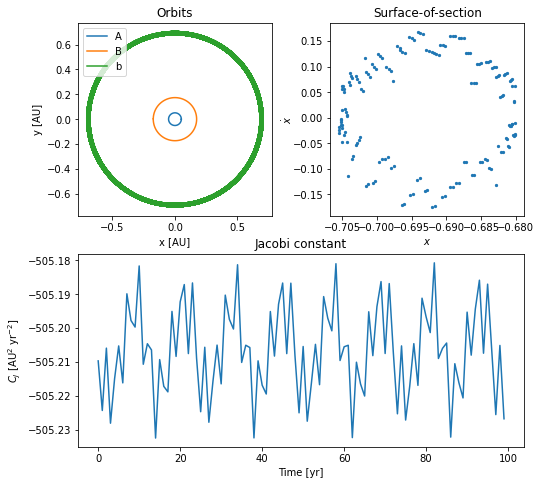

In [236]:
plot_system(sys1a, nstep=1000)

In [237]:
sys1a.orbit_final

{'a': 0.7020816374916115,
 'e': 0.032269236854668405,
 'omega': -0.36298401187547075}

Similar to the first system but with the phase reversed, so that the planet starts closer to the less massive star.

In [238]:
sys2 = CircularThreeBody(m1, m2, sep, a0, phase=0.5)
hist = sys2.integrate(1e4, 1e-3)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [21:09<00:00,  7.88it/s]


The plots for this system are very similar to the previous one. The surface-of-section plot seems to be slightly more compact, suggesting a small increase in stability over the first system.

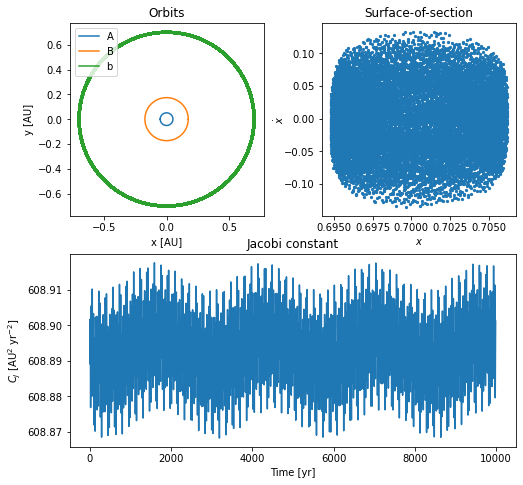

In [239]:
plot_system(sys2, nstep=10000)

The final orbit semi-major-axis is a bit larger than the first system, but the eccentricity is slightly lower. This system seems as stable, if not slightly more so, than the first.

In [240]:
sys2.orbit_final

{'a': 0.7146198301314775,
 'e': 0.02100227415038692,
 'omega': -0.47041763577214357}

## Part 2: Close Orbit

Now the planet starts at half the distance from the system barycenter. It lasts barely over 2 years and 4 orbits before  a close encounter with the secondary and then the primary ejects it from the system.

In [171]:
sys3 = CircularThreeBody(m1, m2, sep, a0/2, phase=0)
hist = sys3.integrate(1e4, 1e-3)

  0%|                                                                                | 4/10000 [00:00<06:32, 25.47it/s]

System is unbound! Stopping integration in 1 year.


The Jacobi integral stays more or less constant until the encounter with the binary. This may be a numerical precision problem as the planet gets too close for the minimum time step, or it may be that in reality the encounter would be a collision.

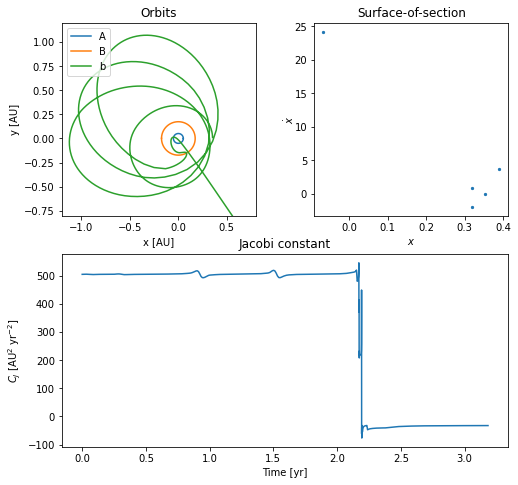

In [210]:
plot_system(sys3, xlim=(-1.2, 0.8), ylim=(-0.8, 1.2))

As proof that the orbit is unbound, here we see that the eccentricity has increased beyond 1.

In [241]:
sys3.orbit_final

{'a': -2.7981941813197673, 'e': 1.0000550685683631, 'omega': 2.151479721628802}

This system is unstable enough that a small change in initial conditions results in a very different final state, as shown here.

In [223]:
sys3a = CircularThreeBody(m1, m2, sep, a0/2.001, phase=0)
hist = sys3a.integrate(1e4, 1e-3)

  0%|                                                                                | 3/10000 [00:00<10:45, 15.50it/s]

System is unbound! Stopping integration in 1 year.


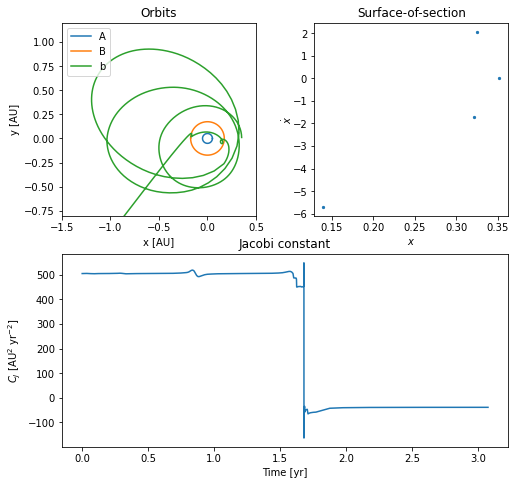

In [224]:
plot_system(sys3a, xlim=(-1.5, 0.5), ylim=(-0.8, 1.2))

Now the case where the planet starts closer to the lower mass component. This configuration is even *less* stable than the previous system, and results in the planet being flung out after just one orbit. There isn't a close encounter or collision, but the binary still drives the planet to higher and higher eccentricity. It makes sense that the secondary-planet conjunction would be less stable than the primary-planet conjuction because the secondary is on the outer orbit and therefore can get much closer to the planet than the primary. Even though the primary is more massive, the force goes as $r^{-2}$ so distance wins at such small separations.

In [242]:
sys4 = CircularThreeBody(m1, m2, sep, a0/2, phase=0.5)
hist = sys4.integrate(1e4, 1e-3)

  0%|                                                                               | 5/10000 [00:00<01:29, 111.07it/s]

System is unbound! Stopping integration in 1 year.


The Jacobi integral is more or less constant, except for one instant which I suspect hapens at the second periastron. That's the encounter that kicks the planet out of the system.

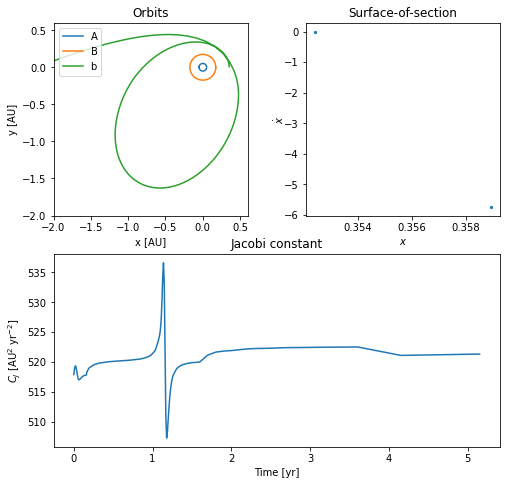

In [243]:
plot_system(sys4, xlim=(-2, 0.6))

It seems like machine precision was a bit of an issue with the automatic stopping condition, as the eccentricity has dipped back slightly below 1. But this is close enough that I think we can consider it gone forever.

In [246]:
sys4.orbit_final

{'a': 55.99589475699574, 'e': 0.9944628888591283, 'omega': 0.7596948600766665}

Once again, this is a chaotic system, and a slight decrease in the initial separation leads to a quantitatively dramatically different result. Qualitatively, the planet is still quickly ejected.

In [247]:
sys4a = CircularThreeBody(m1, m2, sep, a0/2.001, phase=0.5)
hist = sys4a.integrate(1e4, 1e-3)

  0%|                                                                                | 3/10000 [00:00<02:48, 59.40it/s]

System is unbound! Stopping integration in 1 year.


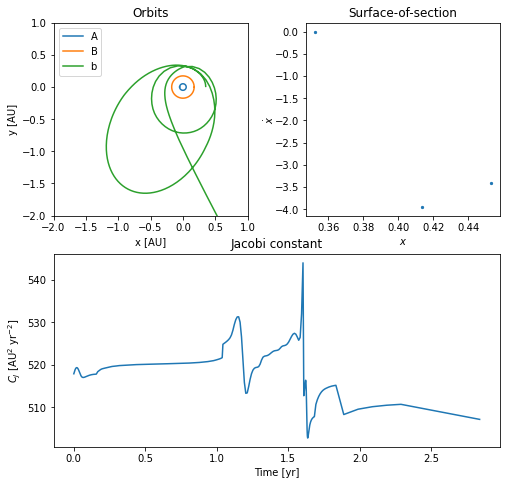

In [248]:
plot_system(sys4a, xlim=(-2, 1))

In [249]:
sys4a.orbit_final

{'a': -0.25695227714511504,
 'e': 2.161685956600884,
 'omega': -3.135370550882863}